# Assignment 2: Function Approximation for Q Learning

Name: Nutcha Temiyasathit

ID: A53249944

### 1. Cartpole

A cartpole problem is shown below.
![pendulum2.png](pendulum2.png)

The equation for the cartpole problem is nonlinear in nature, but it has been shown through robust control theory that a linear version of the equation of the form $\dot{x} = Ax+Bu$ can be solved by a linear controller. Let us assume that we are interested in minimizing cart stray from the center, and pendulum falling. It turns out that typical techniques - open loop control, PID control, root locus, etc. is not suitable for stabilizing both the cart position (keep near center) or the pole angle (keep vertical). The solution to this question is a linear quadratic controller, but we won't be using the solution at the moment.

### Setup Environment for Function Approximation


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import copy 

# Create the CartPole game environment
env = gym.make('CartPole-v0')
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.0165086 ,  0.04584295, -0.03371705,  0.03945258])

#### Demonstrate your understanding of the simulation
For OpenAI's CartPole-v0 environment,
- describe the reward system
- describe the each state variable (observation space)
- describe the action space

Ans:
<ul>
<li> Reward - +1 every time the pole remains upright </li>
<li> State - cart position, cart velocity, pole angle, pole angular velociy</li>
<li> Action - pushing cart to the left or right </li>
</ul>

### Write a Deep Neural Network class that creates a dense network of a desired architecture
In this problem we will create neural network that is our function that takes states to q-values: $q=f(x)$. While any function approximator could be used (i.e. Chebyshev functions, taylor series polynomials), neural networks offer a most general form of 1st-order smooth function (though comprising of trivial small activation functions means that complex functions require a significant amount of weights to identify). 

Create a class for a QNetwork that uses PyTorch to create a fully connected sequential neural network, of the following properties:
- solver: Adam

- input and hidden layer activation function: tanh

- output activation function: linear

- loss: mse

- learning_rate: variable

- decay_rate: variable

- hidden_state sizes: variable

- state and action sizes: variable


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor, LongTensor, ByteTensor

class QNetwork(nn.Module):
    def __init__(self, learning_rate, state_size, action_size, hidden_size, alpha_decay):
        super(QNetwork, self).__init__()
        self.l1 = nn.Linear(state_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, action_size)
        
        self.loss_fn = nn.MSELoss()
        self.learning_rate = learning_rate
        self.alpha_decay = alpha_decay
   
    def forward(self, x):
        x = F.tanh(x)
        x = F.tanh(self.l1(x))
        x = self.l2(x)
        return x

#### Write a Replay class that includes all the functionality of a replay buffer
The replay buffer should kept to some maximum size (10000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). The replay buffer should also be able to generate a minibatch. The generate_minibatch method should take in DQN, targetDQN, selected batch_size, and return the states present in the minibatch and the target Q values for those states.

In [3]:
class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.  
    def __init__(self, max_size):
        self.max_size = max_size
        self.memory = []
        
    def push(self, transition):
        self.memory.append(transition)
        if(len(self.memory)) > self.max_size:
            del self.memory[0]
    
    def initialize(self, init_length, envir):
        state = envir.reset()
        for i in range(init_length):
            action = np.random.randint(2)
            next_state, reward, done, _ = envir.step(action)
            transition = (FloatTensor([state]), 
                          LongTensor([[action]]),
                          FloatTensor([reward]), 
                          FloatTensor([next_state]), done)
            self.push(transition)
            if done:
                state = envir.reset()
            else:
                state = next_state
        
    def generate_minibatch(self, DQN, targetDQN, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)
        
        batch_state_v = Variable(torch.cat(batch_state))
        batch_action_v = Variable(torch.cat(batch_action))
        batch_reward_v = Variable(torch.cat(batch_reward))
        batch_next_state_v = Variable(torch.cat(batch_next_state))
        
        batch_action_v = batch_action_v.view(batch_size, 1)
        
        q_a = DQN(batch_state_v).gather(1, batch_action_v)
             
        not_done_mask = Variable(torch.from_numpy(1-np.array(list(batch_done)))).float()
        
        target_q = not_done_mask * gamma* (targetDQN(batch_next_state_v).detach().max(1)[0])
        target_q = batch_reward_v + target_q
            
        return batch_state_v.data.numpy(), (target_q, q_a)

Write a function that creates a minibatch from a buffer

### Perform Function Approximation
Initialize DQN networks and Replay objects

In [4]:
# Initialize DQN
# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough
learning_rate = 0.001
state_size = 4
action_size = 2
hidden_size = 256
batch_size = 64
alpha_decay = 0.5

DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)

optimizer = optim.Adam(DQN.parameters(), lr=learning_rate)

# set targetDQN weights to DQN weights
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)
targetDQN.load_state_dict(DQN.state_dict())


## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, envir=env)

#### Create a function that solves the above environment using a deep Q network that uses a minibatch strategy.
Use the following parameters (these had to be derived empirically - there is generally no trusted way of choosing the right parameter values - i.e. gamma, number of episodes, decay rate, min_epsilon). 

Generate a graph of the average return per episode every 100 episodes.

In [5]:
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.99                    # future reward discount
max_steps = 500                # cut off simulation after this many steps

# Exploration parameters
min_epsilon = 0.05             # minimum exploration probability
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)

for ep in range(1, num_episodes):
    total_reward = 0
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    state = env.reset()
    done = False
    
    # --> start episode 
    # explore/exploit and get action using DQN
    # perform action and record new_state, action, reward
    # populate Replay experience buffer
    # <-- end episode
    
    while not done:  
        rand = random.random()
        action = LongTensor([[np.random.randint(2)]])
        
        if rand > epsilon:
            action = DQN(Variable(FloatTensor([state]), volatile=True)).data.max(1)[1].view(1, 1)
        
        next_state, reward, done, _ = env.step(action[0,0])
        
        replay.push((FloatTensor([state]), 
                     action,
                     FloatTensor([reward]), 
                     FloatTensor([next_state]), 
                     done))
    
        total_reward += reward
        state = next_state
        
        # Replay
        states, qvalues = replay.generate_minibatch(DQN, targetDQN, batch_size)

        optimizer.zero_grad()
        (y_true, y_pred) = qvalues
        loss = DQN.loss_fn(y_pred, y_true)
        loss.backward()
        for param in DQN.parameters():
            param.grad.data.clamp_(-1,1)
        optimizer.step()
    
    returns[ep] = total_reward
    
    targetDQN.load_state_dict(DQN.state_dict())

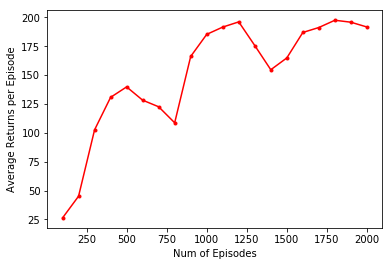

In [6]:
# plot average returns
returns_over_100_episodes = []
x = []
for i in range(0,int(num_episodes/100)):
    returns_over_100_episodes.append(sum(returns[100*i:100*(i+1)-1])/100)
    x.append((i+1)*100)
plt.plot(x,returns_over_100_episodes,'.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Num of Episodes')
plt.show()
    

In [7]:
# DEMO FINAL NETWORK
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, state.size])
total_reward = 0
for i in range(0, max_steps):
    env.render()
    
    # Get action from Q-network
    Qs = DQN(Variable(FloatTensor([state]))).data.numpy()[0]
    action = np.argmax(Qs)
    
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    if done:
        break
    else:
        state = np.reshape(next_state, [1, state.size])
